In [425]:
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

sns.set_theme()
%matplotlib inline

In [429]:
json_results_file = '../predictions/multiple_imputation_median_pooling.json'

predictions = None
with open(json_results_file, 'r') as file:
    data_json = json.load(file)
    for model_full_name, df_data in data_json.items():
        model_short_name = model_full_name.split('_')[0]
        predictions = pd.DataFrame(df_data)
        break

predictions.head()

,y_test,binary_predictions,probabilities,patient_id
0,0,0,0.151226,25312
1,0,1,0.633058,59342
2,0,0,0.007471,50777
3,0,0,0.049166,46918
4,0,0,0.012339,34377


In [428]:
data_file = '../data/training_v2.csv'
data = pd.read_csv(data_file)
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [430]:
predictions = predictions.join(data, on='patient_id', rsuffix='_data', how='left')[['y_test', 'probabilities', 'age', 'ethnicity', 'gender']]
predictions = predictions.rename(columns={'y_test': 'labels', 'probabilities': 'predictions'})
predictions.head()

,labels,predictions,age,ethnicity,gender
0,0,0.151226,57.0,African American,F
1,0,0.633058,48.0,Caucasian,M
2,0,0.007471,34.0,Caucasian,F
3,0,0.049166,60.0,Caucasian,F
4,0,0.012339,80.0,Caucasian,F


In [431]:
data = pd.read_csv("XGBClassifier_predictions.csv")

In [457]:
def plot_roc_curves(df, column_name, label_col="labels", pred_col="predictions", value_names={}):
  unique_values = sorted(df[column_name].unique())

  plt.figure(figsize=(10, 6))
  for i, value in enumerate(unique_values):
    group_data = df[df[column_name] == value]
    y_true = group_data[label_col]
    y_pred = group_data[pred_col]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    label = value_names.get(value, value)  # Use custom label if available
    auc_score = np.round(auc(fpr, tpr), 3)
    plt.plot(fpr, tpr, label=f'{label} (AUROC={auc_score})')

  # Add subtle y=x line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)

  # Customize plot and display
  plt.xlabel("1 - Specificity (False Positive Rate)")
  plt.ylabel("Sensitivity (True Positive Rate)")
  # plt.title(f"ROC Curves by {column_name}")
  plt.legend(title=column_name)
  plt.grid(True)
  plt.show()

In [458]:
def plot_precision_recall_curves(df, column_name, label_col="labels", pred_col="predictions", value_names={}):
  unique_values = sorted(df[column_name].unique())

  plt.figure(figsize=(10, 6))
  for i, value in enumerate(unique_values):
    group_data = df[df[column_name] == value]
    y_true = group_data[label_col]
    y_pred = group_data[pred_col]
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    label = value_names.get(value, value)  # Use custom label if available
    auc_score = np.round(auc(recall, precision), 3)
    plt.plot(recall, precision, label=f'{label} (PRAUC={auc_score})')

  # Customize plot and display
  plt.xlabel("Recall (Sensitivity)")
  plt.ylabel("Precision (Positive Predictive Value)")
  # plt.title(f"Precision-Recall Curves by {column_name}")
  plt.legend(title=column_name)
  plt.grid(True)
  plt.show()

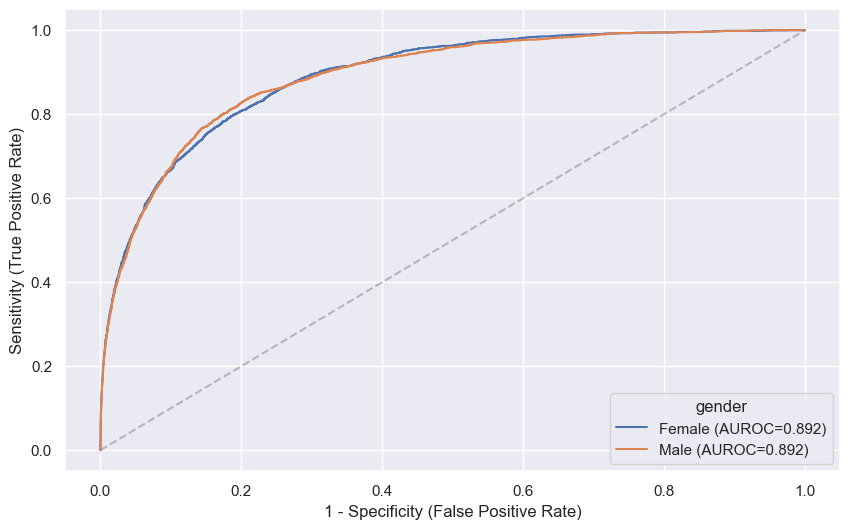

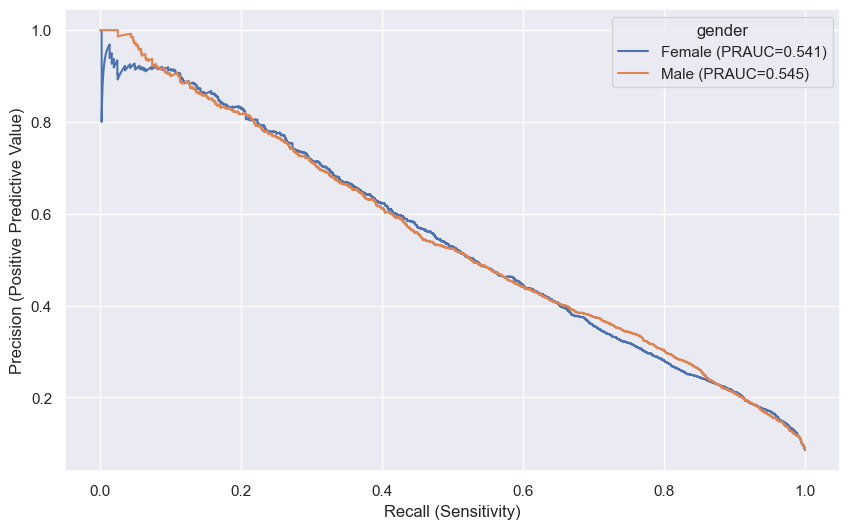

In [459]:
gender_labels = {
  'F': 'Female',
  'M': 'Male'
}

data_gender_drop_na = pd.DataFrame(predictions)
data_gender_drop_na.dropna(inplace=True)

plot_roc_curves(data_gender_drop_na, 'gender', value_names=gender_labels)
plot_precision_recall_curves(data_gender_drop_na, 'gender', value_names=gender_labels)

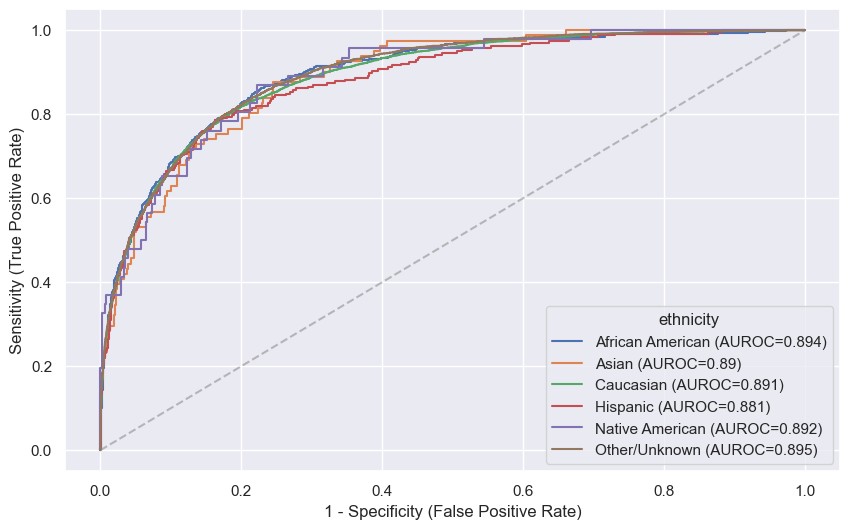

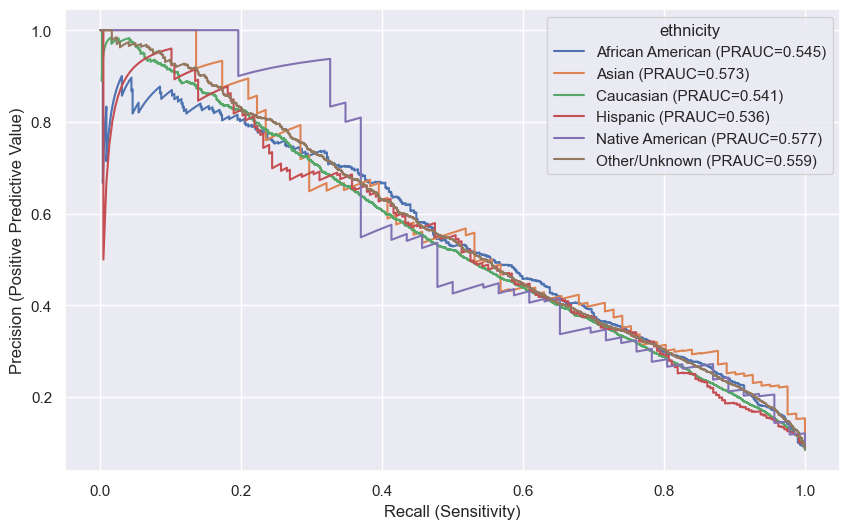

In [460]:
predictions['ethnicity'] = predictions['ethnicity'].fillna('Other/Unknown')
plot_roc_curves(predictions, 'ethnicity')
plot_precision_recall_curves(predictions, 'ethnicity')

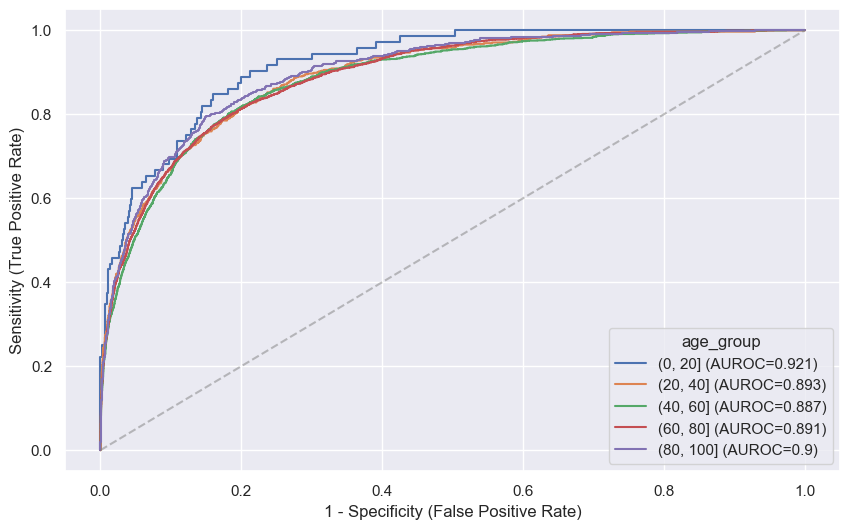

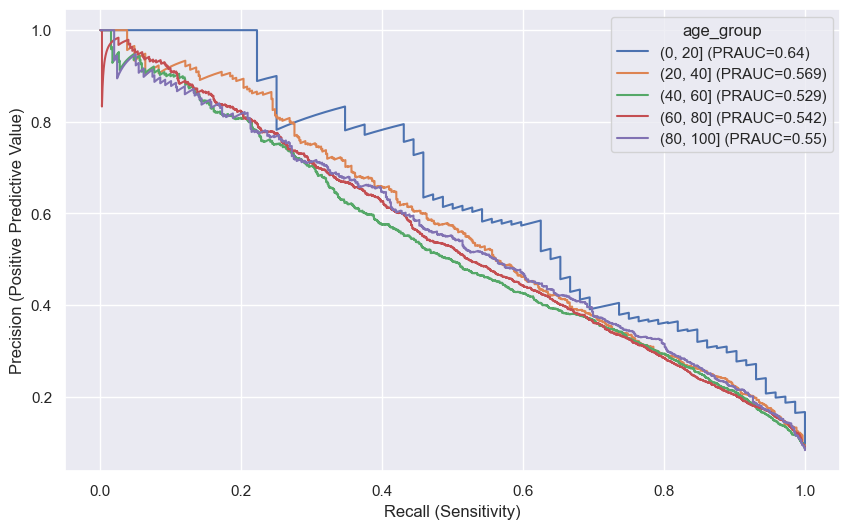

In [461]:
# Define age groups with 20-year steps
age_groups = range(0, 101, 20)
age_groups_labels = [pd.Interval(left=b, right=b+20) for b in range(0, 101, 20)]

# Use pd.cut to create the age group column based on boundaries and labels
data_with_age_groups = predictions.copy()

# data_with_age_groups['age_group'] = pd.cut(data_with_age_groups['age'], age_groups, labels=age_groups[:-1])
data_with_age_groups['age_group'] = pd.cut(data_with_age_groups['age'], age_groups, labels=age_groups_labels[:-1])
data_with_age_groups.dropna(inplace=True)

plot_roc_curves(data_with_age_groups, 'age_group')
plot_precision_recall_curves(data_with_age_groups, 'age_group')

In [344]:
data_with_age_groups.to_csv('XGBClassifier_predictions_with_protected_groups.csv')

In [404]:
sorted_data_by_pred = data_with_age_groups.sort_values('predictions', ascending=False)
top_pred_dict = {
    'Top 10': sorted_data_by_pred.head(10),
    'Top 30': sorted_data_by_pred.head(30),
    'Top 50': sorted_data_by_pred.head(50),
    'Top 100': sorted_data_by_pred.head(100),
}

groups_for_top_pred = {
    'gender': [gender for gender in data_with_age_groups['gender'].unique().tolist()],
    'ethnicity': [gender for gender in data_with_age_groups['ethnicity'].unique().tolist()],
}

top_pred_df = pd.DataFrame(columns=[key for key in top_pred_dict.keys()])

for top_index in top_pred_dict.keys():
    for group in groups_for_top_pred.keys():
        subgroups_percentages = top_pred_dict[top_index][group].value_counts()
        for subgroup in groups_for_top_pred[group]:
            if subgroup in subgroups_percentages.index:
                print(f'{top_index} - {subgroup}: {subgroups_percentages[subgroup]}')
                top_pred_df.loc[subgroup, top_index] = np.round(subgroups_percentages[subgroup] * 100 / top_pred_dict[top_index].shape[0], 2)
            else:
                print(f'{top_index} - {subgroup}: 0')
                top_pred_df.loc[subgroup, top_index] = 0
top_pred_df

Top 10 - F: 4
Top 10 - M: 6
Top 10 - African American: 0
Top 10 - Caucasian: 8
Top 10 - Other/Unknown: 0
Top 10 - Hispanic: 0
Top 10 - Asian: 2
Top 10 - Native American: 0
Top 30 - F: 15
Top 30 - M: 15
Top 30 - African American: 1
Top 30 - Caucasian: 26
Top 30 - Other/Unknown: 1
Top 30 - Hispanic: 0
Top 30 - Asian: 2
Top 30 - Native American: 0
Top 50 - F: 22
Top 50 - M: 28
Top 50 - African American: 1
Top 50 - Caucasian: 43
Top 50 - Other/Unknown: 4
Top 50 - Hispanic: 0
Top 50 - Asian: 2
Top 50 - Native American: 0
Top 100 - F: 46
Top 100 - M: 54
Top 100 - African American: 3
Top 100 - Caucasian: 84
Top 100 - Other/Unknown: 8
Top 100 - Hispanic: 0
Top 100 - Asian: 5
Top 100 - Native American: 0


,Top 10,Top 30,Top 50,Top 100
F,40.0,50.0,44.0,46.0
M,60.0,50.0,56.0,54.0
African American,0,3.33,2.0,3.0
Caucasian,80.0,86.67,86.0,84.0
Other/Unknown,0,3.33,8.0,8.0
Hispanic,0,0,0,0
Asian,20.0,6.67,4.0,5.0
Native American,0,0,0,0


## Multi-Calibration

In [596]:
def calculate_calibration_in_the_large(subgroup_df: pd.DataFrame, predictions_column_name):
    """Calculates the odds ratio for a given subgroup using your formula.

    Args:
        subgroup_df (pd.DataFrame): A DataFrame containing data for a specific subgroup.

    Returns:
        float: The odds ratio for the subgroup using your formula.
    """
    
    avg_prediction = subgroup_df[predictions_column_name].mean()
    avg_outcome = subgroup_df["labels"].mean()

    if avg_prediction == 1 or avg_outcome == 0 or avg_outcome == 1:
        # Handle cases where division by zero would occur
        return None

    # Calculate odds ratio using your formula
    calibration_in_the_large = (avg_prediction / (1 - avg_prediction)) / (avg_outcome / (1 - avg_outcome))

    return np.round(calibration_in_the_large, 3)

In [629]:
data_with_age_groups['calibrated_predictions'] = data_with_age_groups['predictions']
subgroups_group_by = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])
subgroups_df = subgroups_group_by.count().reset_index()

protected_groups_dict = { str(subgroup.values[:3]): {'nudge': 0} for index, subgroup in subgroups_df.iterrows()}
protected_groups_dict

/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/3853375780.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups_group_by = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])


{"[Interval(0, 20, closed='right') 'F' 'African American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Asian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Caucasian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Hispanic']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Native American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Other/Unknown']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'African American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Asian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Caucasian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Hispanic']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Native American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Other/Unknown']": {'nudge': 0},
 "[Interval(20, 40, closed='right') 'F' 'African American']": {'nudge': 0},
 "[Interval(20, 40, closed='right') 'F' 'Asian']": {'nudge': 0},
 "[Interval(20, 40,

In [630]:
alpha = 0.005
done = False
while not done:
    done = True
    for group_index, subgroup in subgroups_df.iterrows():
        subgroup_df = data_with_age_groups.loc[(data_with_age_groups['age_group'] == subgroup['age_group']) & (data_with_age_groups['gender'] == subgroup['gender']) & (data_with_age_groups['ethnicity'] == subgroup['ethnicity']),]
        subgroup_id = str(subgroup.values[:3])
        sum_y = subgroup_df['labels'].sum()
        sum_p = subgroup_df['calibrated_predictions'].sum()
        violation = np.mean(subgroup_df['labels'] - subgroup_df['calibrated_predictions'])
        if np.abs(violation) > alpha:
            print(f'subgroup: {subgroup_id}, violation: {violation} (sum_y = {sum_y}, sum_p = {sum_p}), count: {subgroup_df.shape[0]}')
            violation *= 0.1
            data_with_age_groups.loc[(data_with_age_groups['age_group'] == subgroup['age_group']) & (data_with_age_groups['gender'] == subgroup['gender']) & (data_with_age_groups['ethnicity'] == subgroup['ethnicity']), 'calibrated_predictions'] += violation
            done = False

subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], violation: 0.048527393835566694 (sum_y = 10, sum_p = 6.991301582194865), count: 62
subgroup: [Interval(0, 20, closed='right') 'F' 'Asian'], violation: -0.07287176698446274 (sum_y = 0, sum_p = 0.43723060190677643), count: 6
subgroup: [Interval(0, 20, closed='right') 'F' 'Caucasian'], violation: 0.012650648154724473 (sum_y = 26, sum_p = 22.63492759084329), count: 266
subgroup: [Interval(0, 20, closed='right') 'F' 'Hispanic'], violation: -0.0163075774360229 (sum_y = 1, sum_p = 1.2772288164123893), count: 17
subgroup: [Interval(0, 20, closed='right') 'F' 'Native American'], violation: -0.03744132025167346 (sum_y = 0, sum_p = 0.486737163271755), count: 13
subgroup: [Interval(0, 20, closed='right') 'F' 'Other/Unknown'], violation: -0.02633256249985582 (sum_y = 2, sum_p = 2.9743048124946654), count: 37
subgroup: [Interval(0, 20, closed='right') 'M' 'Asian'], violation: -0.07324006594717503 (sum_y = 0, sum_p = 0.43944039568305

In [682]:
subgroups_after_calibration_df = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])
sorted_groups = subgroups_after_calibration_df.size()

calibration_in_the_large = pd.DataFrame()
calibration_in_the_large['before_calibration_log'] = np.log10(subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions')))
calibration_in_the_large['after_calibration_log'] = np.log10(subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions')))
calibration_in_the_large['before_calibration'] = subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions'))
calibration_in_the_large['after_calibration'] = subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions'))
calibration_in_the_large.dropna(inplace=True)
sorted_groups = sorted_groups.loc[calibration_in_the_large.isna().index]
sorted_groups.sort_values(ascending=True, inplace=True)

calibration_in_the_large.set_index(sorted_groups.index, inplace=True)
calibration_in_the_large['groups_size'] = sorted_groups
calibration_in_the_large

/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/3514866151.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups_after_calibration_df = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])


before_calibration_log  \
age_group gender ethnicity                                  
(0, 20]   M      Native American                -0.179799   
(80, 100] M      Native American                -0.066007   
(0, 20]   F      Hispanic                        0.113943   
(80, 100] F      Native American                 0.184691   
(0, 20]   M      Hispanic                        0.008600   
          F      Other/Unknown                   0.044540   
(20, 40]  M      Asian                          -0.369572   
(80, 100] F      Asian                           0.006894   
(0, 20]   M      African American               -0.003051   
                 Other/Unknown                  -0.132533   
(80, 100] M      Asian                           0.044148   
(20, 40]  F      Asian                          -0.034328   
(0, 20]   F      African American                0.035430   
(60, 80]  M      Native American                 0.762303   
(20, 40]  M      Native American                -0.075204   
          F      Native American                -0.018181   
(60, 80]  F      Native American                -0.135489   
(40, 60]  F      Asian                          -0.050610   
                 Native American                -0.151195   
          M      Asian                          -0.154902   
                 Native American                -0.042872   
(60, 80]  F      Asian                          -0.008331   
(20, 40]  F      Hispanic                       -0.221849   
          M      Hispanic                       -0.028724   
(60, 80]  M      Asian                          -0.083546   
(80, 100] M      African American                0.028571   
                 Other/Unknown                   0.025306   
          F      Other/Unknown                  -0.030584   
          M      Hispanic                        0.115278   
          F      Hispanic                       -0.029188   
                 African American               -0.040005   
(0, 20]   M      Caucasian                      -0.118045   
          F      Caucasian                       0.030195   
(20, 40]  F      Other/Unknown                  -0.041436   
(40, 60]  F      Hispanic                       -0.143876   
(20, 40]  M      Other/Unknown                  -0.024109   
(40, 60]  M      Hispanic                       -0.057000   
(60, 80]  F      Hispanic                       -0.038579   
(40, 60]  F      Other/Unknown                  -0.040005   
(60, 80]  M      Hispanic                       -0.078834   
(20, 40]  F      African American                0.068928   
          M      African American               -0.012334   
(60, 80]  F      Other/Unknown                  -0.076756   
(40, 60]  M      Other/Unknown                   0.351989   
(60, 80]  M      Other/Unknown                  -0.040482   
(40, 60]  F      African American                0.016197   
(60, 80]  F      African American               -0.011441   
          M      African American                0.007748   
(40, 60]  M      African American                0.055760   
(20, 40]  F      Caucasian                      -0.070581   
          M      Caucasian                       0.134496   
(80, 100] M      Caucasian                      -0.097997   
          F      Caucasian                      -0.008331   
(40, 60]  F      Caucasian                      -0.008331   
          M      Caucasian                      -0.082494   
(60, 80]  F      Caucasian                      -0.396856   
          M      Caucasian                      -0.087778   

                                   after_calibration_log  before_calibration  \
age_group gender ethnicity                                                     
(0, 20]   M      Native American               -0.015473               0.661   
(80, 100] M      Native American               -0.024568               0.859   
(0, 20]   F      Hispanic                       0.035029               1.300   
(80, 100] F      Native American   

In [668]:
calculate_calibration_in_the_large(data_with_age_groups, 'predictions')

0.945

In [669]:
calculate_calibration_in_the_large(data_with_age_groups, 'calibrated_predictions')

0.962

In [634]:
subgroups_group_by_age_group = data_with_age_groups.groupby(['age_group'])
age_group_calibration_in_the_large = pd.DataFrame()
age_group_calibration_in_the_large['calibration_in_the_large_before'] = subgroups_group_by_age_group.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions'))
age_group_calibration_in_the_large['calibration_in_the_large_after'] = subgroups_group_by_age_group.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions'))
age_group_calibration_in_the_large.dropna(inplace=True)
age_group_calibration_in_the_large

/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/2299377789.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups_group_by_age_group = data_with_age_groups.groupby(['age_group'])


,calibration_in_the_large_before,calibration_in_the_large_after
age_group,,
"(0, 20]",0.947,0.999
"(20, 40]",0.893,0.949
"(40, 60]",0.942,0.953
"(60, 80]",0.945,0.958
"(80, 100]",0.993,0.999


In [635]:
subgroups_group_by_gender = data_with_age_groups.groupby(['gender'])
gender_calibration_in_the_large = pd.DataFrame()
gender_calibration_in_the_large['calibration_in_the_large_before'] = subgroups_group_by_gender.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions'))
gender_calibration_in_the_large['calibration_in_the_large_after'] = subgroups_group_by_gender.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions'))
gender_calibration_in_the_large.dropna(inplace=True)
gender_calibration_in_the_large

,calibration_in_the_large_before,calibration_in_the_large_after
gender,,
F,0.946,0.961
M,0.944,0.962


In [636]:
subgroups_group_by_ethnicity = data_with_age_groups.groupby(['ethnicity'])
ethnicity_calibration_in_the_large = pd.DataFrame()
ethnicity_calibration_in_the_large['calibration_in_the_large_before'] = subgroups_group_by_ethnicity.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions'))
ethnicity_calibration_in_the_large['calibration_in_the_large_after'] = subgroups_group_by_ethnicity.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions'))
ethnicity_calibration_in_the_large.dropna(inplace=True)
ethnicity_calibration_in_the_large

,calibration_in_the_large_before,calibration_in_the_large_after
ethnicity,,
African American,0.895,0.955
Asian,0.905,1.003
Caucasian,0.954,0.960
Hispanic,0.876,0.961
Native American,1.022,0.995
Other/Unknown,0.965,0.984


Max calibration: subpopulation - (Interval(60, 80, closed='right'), 'M', 'Native American'), before: 0.7623033632877684, after: 0.12123145514962146, index: 13
Min calibration: subpopulation - (Interval(60, 80, closed='right'), 'F', 'Caucasian'), value: -0.39685562737981767, after: -0.022733787572707352, index: 55
Variance before: 0.4708859636811328, after: 0.005141499538319487, ratio (before / after): 91.58533617899403


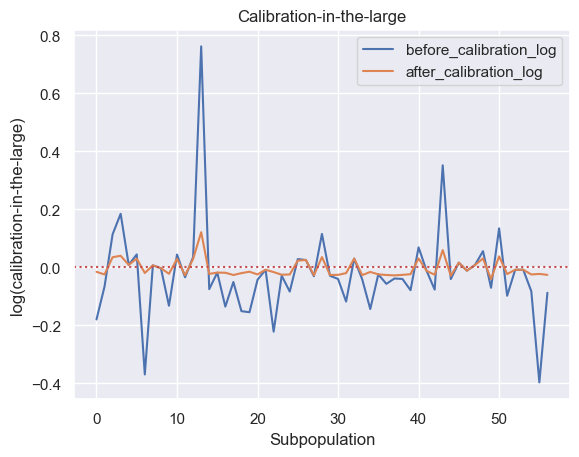

In [683]:
calibration_in_the_large[['before_calibration_log', 'after_calibration_log']].reset_index().plot(title='Calibration-in-the-large', ylabel='log(calibration-in-the-large)', xlabel='Subpopulation')
plt.axhline(y=0, color='r', linestyle=':')

max_subgroup_before_index = calibration_in_the_large['before_calibration_log'].argmax()
max_subgroup_before_value = calibration_in_the_large.loc[calibration_in_the_large.index[max_subgroup_before_index], 'before_calibration_log']
max_subgroup_after_value = calibration_in_the_large.loc[calibration_in_the_large.index[max_subgroup_before_index], 'after_calibration_log']
max_subgroup_before_name = calibration_in_the_large.index[max_subgroup_before_index]
print(f'Max calibration: subpopulation - {max_subgroup_before_name}, before: {max_subgroup_before_value}, after: {max_subgroup_after_value}, index: {max_subgroup_before_index}')

min_subgroup_before_index = calibration_in_the_large['before_calibration_log'].argmin()
min_subgroup_before_value = calibration_in_the_large.loc[calibration_in_the_large.index[min_subgroup_before_index], 'before_calibration_log']
min_subgroup_after_value = calibration_in_the_large.loc[calibration_in_the_large.index[min_subgroup_before_index], 'after_calibration_log']
min_subgroup_before_name = calibration_in_the_large.index[min_subgroup_before_index]
print(f'Min calibration: subpopulation - {min_subgroup_before_name}, value: {min_subgroup_before_value}, after: {min_subgroup_after_value}, index: {min_subgroup_before_index}')

variance_before = np.var(calibration_in_the_large['before_calibration'])
variance_after = np.var(calibration_in_the_large['after_calibration'])
print(f'Variance before: {variance_before}, after: {variance_after}, ratio (before / after): {variance_before / variance_after}')

In [638]:
sorted_data_by_calibrated_pred = data_with_age_groups.sort_values('calibrated_predictions', ascending=False)
top_calibrated_pred_dict = {
    'Top 10': sorted_data_by_calibrated_pred.head(10),
    'Top 30': sorted_data_by_calibrated_pred.head(30),
    'Top 50': sorted_data_by_calibrated_pred.head(50),
    'Top 100': sorted_data_by_calibrated_pred.head(100),
}

groups_for_top_calibrated_pred = {
    'gender': [gender for gender in data_with_age_groups['gender'].unique().tolist()],
    'ethnicity': [gender for gender in data_with_age_groups['ethnicity'].unique().tolist()],
    'age_group': [gender for gender in data_with_age_groups['age_group'].unique().tolist()],
}

# print(json.dumps(groups_for_top_calibrated_pred, indent=4))

top_calibrated_pred_df = pd.DataFrame(columns=[key for key in top_calibrated_pred_dict.keys()])

for top_index in top_calibrated_pred_dict.keys():
    for group in groups_for_top_calibrated_pred.keys():
        subgroups_percentages = top_calibrated_pred_dict[top_index][group].value_counts()
        for subgroup in groups_for_top_calibrated_pred[group]:
            if subgroup in subgroups_percentages.index:
                print(f'{top_index} - {subgroup}: {subgroups_percentages[subgroup]}')
                top_calibrated_pred_df.loc[subgroup, top_index] = np.round(subgroups_percentages[subgroup] * 100 / top_calibrated_pred_dict[top_index].shape[0], 2)
            else:
                print(f'{top_index} - {subgroup}: 0')
                top_calibrated_pred_df.loc[subgroup, top_index] = 0
top_calibrated_pred_df

Top 10 - F: 5
Top 10 - M: 5
Top 10 - African American: 1
Top 10 - Caucasian: 5
Top 10 - Other/Unknown: 0
Top 10 - Hispanic: 0
Top 10 - Asian: 3
Top 10 - Native American: 1
Top 10 - (40, 60]: 1
Top 10 - (20, 40]: 1
Top 10 - (60, 80]: 6
Top 10 - (80, 100]: 2
Top 10 - (0, 20]: 0
Top 30 - F: 16
Top 30 - M: 14
Top 30 - African American: 1
Top 30 - Caucasian: 23
Top 30 - Other/Unknown: 2
Top 30 - Hispanic: 0
Top 30 - Asian: 3
Top 30 - Native American: 1
Top 30 - (40, 60]: 5
Top 30 - (20, 40]: 3
Top 30 - (60, 80]: 15
Top 30 - (80, 100]: 6
Top 30 - (0, 20]: 1
Top 50 - F: 22
Top 50 - M: 28
Top 50 - African American: 1
Top 50 - Caucasian: 41
Top 50 - Other/Unknown: 3
Top 50 - Hispanic: 0
Top 50 - Asian: 4
Top 50 - Native American: 1
Top 50 - (40, 60]: 11
Top 50 - (20, 40]: 5
Top 50 - (60, 80]: 25
Top 50 - (80, 100]: 8
Top 50 - (0, 20]: 1
Top 100 - F: 46
Top 100 - M: 54
Top 100 - African American: 3
Top 100 - Caucasian: 83
Top 100 - Other/Unknown: 7
Top 100 - Hispanic: 1
Top 100 - Asian: 5
Top 10

,Top 10,Top 30,Top 50,Top 100
F,50.0,53.33,44.0,46.0
M,50.0,46.67,56.0,54.0
African American,10.0,3.33,2.0,3.0
Caucasian,50.0,76.67,82.0,83.0
Other/Unknown,0,6.67,6.0,7.0
Hispanic,0,0,0,1.0
Asian,30.0,10.0,8.0,5.0
Native American,10.0,3.33,2.0,1.0
"(40, 60]",10.0,16.67,22.0,27.0
"(20, 40]",10.0,10.0,10.0,7.0


Text(0.5, 0, 'Calibration-in-the-large')

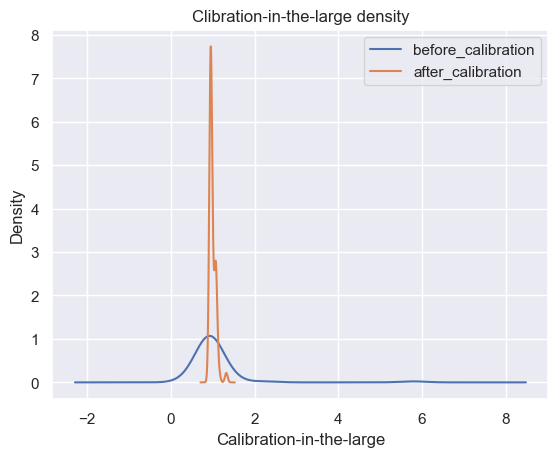

In [645]:
calibration_in_the_large[['before_calibration', 'after_calibration']].plot(kind='density', title='Clibration-in-the-large density', xlabel='calibration-in-the-large')
plt.xlabel('Calibration-in-the-large')

In [651]:
precision, recall, _ = precision_recall_curve(data_with_age_groups['labels'], data_with_age_groups['calibrated_predictions'])
np.round(auc(recall, precision) * 100, 1)

54.4

In [652]:
fpr, tpr, _ = roc_curve(data_with_age_groups['labels'], data_with_age_groups['calibrated_predictions'])
np.round(auc(fpr, tpr) * 100, 1)

89.2

In [139]:
print(json.dumps(protected_groups_dict, indent=4))

{
    "[Interval(0, 20, closed='right') 'F' 'African American']": {
        "nudge": 0.048527393835566694
    },
    "[Interval(0, 20, closed='right') 'F' 'Asian']": {
        "nudge": -0.07287176698446274
    },
    "[Interval(0, 20, closed='right') 'F' 'Caucasian']": {
        "nudge": 0.012650648154724473
    },
    "[Interval(0, 20, closed='right') 'F' 'Hispanic']": {
        "nudge": -0.0163075774360229
    },
    "[Interval(0, 20, closed='right') 'F' 'Native American']": {
        "nudge": -0.03744132025167346
    },
    "[Interval(0, 20, closed='right') 'F' 'Other/Unknown']": {
        "nudge": -0.02633256249985582
    },
    "[Interval(0, 20, closed='right') 'M' 'African American']": {
        "nudge": -0.0021366931840169187
    },
    "[Interval(0, 20, closed='right') 'M' 'Asian']": {
        "nudge": -0.07324006594717503
    },
    "[Interval(0, 20, closed='right') 'M' 'Caucasian']": {
        "nudge": -0.007004905504800263
    },
    "[Interval(0, 20, closed='right') 'M' 'Hi